In [1]:
from dataman.audio_processing import *

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np

import time

## Renewing the data within the database

The first batch of data collected for the database (in "datasets/keystrokes_00") contained too few, too diversified sound data for each key type that no meaningful progress could be made for the supervised proof-of-concept model. To fix this, the data within the database will be overhauled from scratch by recollecting data for each key type once again, with a particular focus on consistency of keystroke sound. By artifically constraining the variance of sound data for each key type, I hope to have an easier time generating meaningful output for the proof of concept.

### Extracting keystroke data from raw WAV files

In [3]:
keystroke_data = collect_keystroke_data('/env/datasets/keystrokes/', output=True)

> Reading files from /env/datasets/keystrokes/a/ for key "a"
  > Extracting keystrokes from "a-x.wav" => Collected 123 keystrokes
> Reading files from /env/datasets/keystrokes/b/ for key "b"
  > Extracting keystrokes from "b-x.wav" => Collected 108 keystrokes
> Reading files from /env/datasets/keystrokes/c/ for key "c"
  > Extracting keystrokes from "c-x.wav" => Collected 156 keystrokes
> Reading files from /env/datasets/keystrokes/d/ for key "d"
  > Extracting keystrokes from "d-x.wav" => Collected 150 keystrokes
> Reading files from /env/datasets/keystrokes/e/ for key "e"
  > Extracting keystrokes from "e-x.wav" => Collected 159 keystrokes
> Reading files from /env/datasets/keystrokes/f/ for key "f"
  > Extracting keystrokes from "f-x.wav" => Collected 195 keystrokes
> Reading files from /env/datasets/keystrokes/g/ for key "g"
  > Extracting keystrokes from "g-x.wav" => Collected 153 keystrokes
> Reading files from /env/datasets/keystrokes/h/ for key "h"
  > Extracting keystrokes fro

### Creating a table in local Postgres db and storing keystroke data (only required the first time)

In [4]:
create_keystroke_table()

In [5]:
store_keystroke_data(keystroke_data, os.environ['TEST_DATABASE_URL'])

### Loading stored data from database

In [6]:
data, labels = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

In [8]:
data

array([[ 1086,  2269,  3287, ...,    17,    17,     8],
       [-1099,  -858,  -332, ...,    -5,     1,    11],
       [  950,   421,  -471, ...,   -34,   -33,   -30],
       ...,
       [ -724,  -949,   539, ...,     0,    -4,    -5],
       [ -545,  -933,  -223, ...,    -7,    -9,    -7],
       [ -828, -1149,   125, ...,    -7,    -5,    -3]])

## Supervised Training (Initial Attempt)

In [28]:
scaled_data = scale_keystroke_data(data)

In [21]:
# 90% training, 10% testing
training_count = int(len(scaled_data) * 0.9)
x_train, x_test = scaled_data[:training_count], scaled_data[training_count:]
y_train, y_test = labels[:training_count], labels[training_count:]

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
3987/3987 [==============================] - 2s 600us/sample - loss: 3.7046 - accuracy: 0.0296
Epoch 2/5
3987/3987 [==============================] - 1s 298us/sample - loss: 3.3659 - accuracy: 0.0416
Epoch 3/5
3987/3987 [==============================] - 1s 306us/sample - loss: 3.3647 - accuracy: 0.0426
Epoch 4/5
3987/3987 [==============================] - 1s 299us/sample - loss: 3.3637 - accuracy: 0.0426
Epoch 5/5
444/444 [==============================] - 0s 402us/sample - loss: 3.3636 - accuracy: 0.0563


[3.3636162946890065, 0.056306306]

The classifying accuracy is ~5.6%, which is pretty low. But I guess this is to be expected due to how similar certain groups of key types sound relative to each other. A logical next step seems to be clustering and visualizing each keystroke to observe whether the the low classifying accuracy is due to keystrokes being extremely indistinguishable or clusters being distinguishable, but lack enough variance between similar clusters.

## Clustering the Data (Initial Attempt)

Clustering the data naively into 29 clusters within a 13,230 dimension space (like below) would likely take a absurdly long time. Instead, I should preprocess the data beforehand to reduce the number of dimensions. The important aspects of each keystroke data are the points and widths of the peaks. Values below the silence threshold don't matter at all, so those portions can just be regarded as "0". So maybe sample each data in with lower frequency, with higher frequency around the first 0.2 seconds or so to capture the peak details.

In [ ]:
kmeans = KMeans(n_clusters=29, random_state=0).fit(scaled_data)

After some research, I've determined that t-SNE (t-Distributed Stochastic Neighbor Embedding) is a good candidate for visualizing the keystroke data within a 2 or 3 dimensional space. sklearn already has it implemented, so I will attempt to use that in order to proceed with my project.

In [2]:
data, labels = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

In [3]:
data

array([[ 1086,  2269,  3287, ...,    17,    17,     8],
       [-1099,  -858,  -332, ...,    -5,     1,    11],
       [  950,   421,  -471, ...,   -34,   -33,   -30],
       ...,
       [ -724,  -949,   539, ...,     0,    -4,    -5],
       [ -545,  -933,  -223, ...,    -7,    -9,    -7],
       [ -828, -1149,   125, ...,    -7,    -5,    -3]])

In [4]:
labels

array([ 0,  0,  0, ..., 28, 28, 28])

### t-SNE Clustering

In [5]:
scaled_data = MinMaxScaler().fit_transform(data)
t0 = time.time()
data_embedded = TSNE().fit_transform(scaled_data)
t1 = time.time()
print(f'Total time elapsed: {t1 - t0}s')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Total time elapsed: 620.7677257061005s


In [6]:
scaled_data

array([[0.55800229, 0.85026551, 0.65004875, ..., 0.62585034, 0.64788732,
        0.576     ],
       [0.36554215, 0.66779483, 0.48967473, ..., 0.47619048, 0.53521127,
        0.6       ],
       [0.54602308, 0.74242866, 0.48351502, ..., 0.27891156, 0.29577465,
        0.272     ],
       ...,
       [0.39857306, 0.66248468, 0.52827262, ..., 0.51020408, 0.5       ,
        0.472     ],
       [0.41433982, 0.66341833, 0.49450501, ..., 0.46258503, 0.46478873,
        0.456     ],
       [0.38941249, 0.65081403, 0.50992644, ..., 0.46258503, 0.49295775,
        0.488     ]])

In [7]:
data_embedded

array([[ -78.98624 ,   49.967606],
       [-100.982544,   94.58794 ],
       [ -85.946594,   49.82785 ],
       ...,
       [ -49.691505,   26.37389 ],
       [  23.23572 ,  -32.015633],
       [ -22.325783,   48.012833]], dtype=float32)

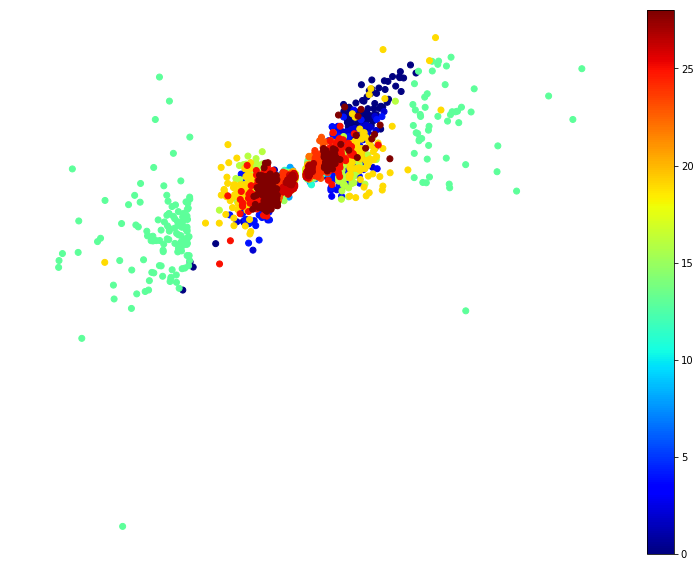

In [8]:
plt.figure(figsize=(13, 10))
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=labels, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

### PCA Clustering

PCA took 2.2046120166778564s


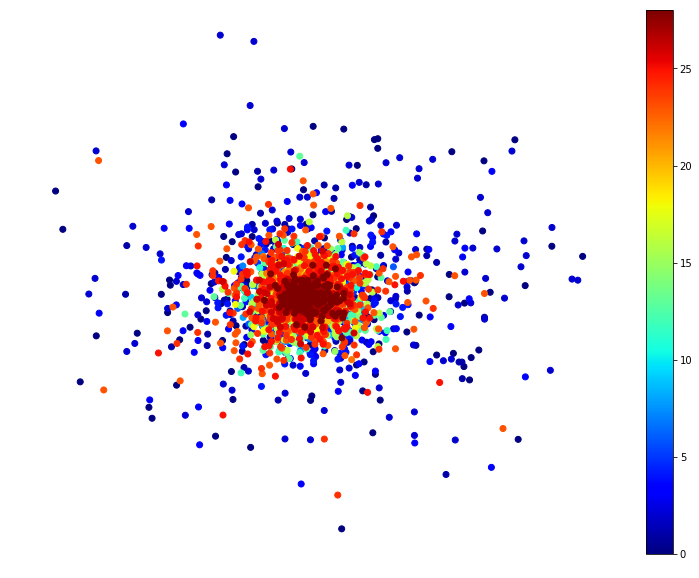

In [12]:
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(scaled_data)
t1 = time.time()
print(f'PCA took {t1 - t0}s')
plt.figure(figsize=(13, 10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=labels, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

## Better Visualization

In [20]:
def plot_keystrokes(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    """Plot keystrokes data X in 2D plane with graphical labels.
    
    Mostly copied from plot_digits() function from:
    https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb
    """
    X_norm = MinMaxScaler().fit_transform(X)
    # Create list of coordinates plotted so far.
    # Initialized with point plotted far from start to bypass if-conditions
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = plt.cm.get_cmap('jet')
    labels = np.unique(y)
    for label in labels:
        plt.scatter(X_norm[y == label, 0], X_norm[y == label, 1], c=[cmap(label / 28)])
    plt.axis('off')
    ax = plt.gcf().gca() # get current axes in current figure
    for index, image_coord in enumerate(X_norm):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                if images is None:
                    plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                             color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
                else:
                    image = images[index]
                    imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                    ax.add_artist(imagebox)

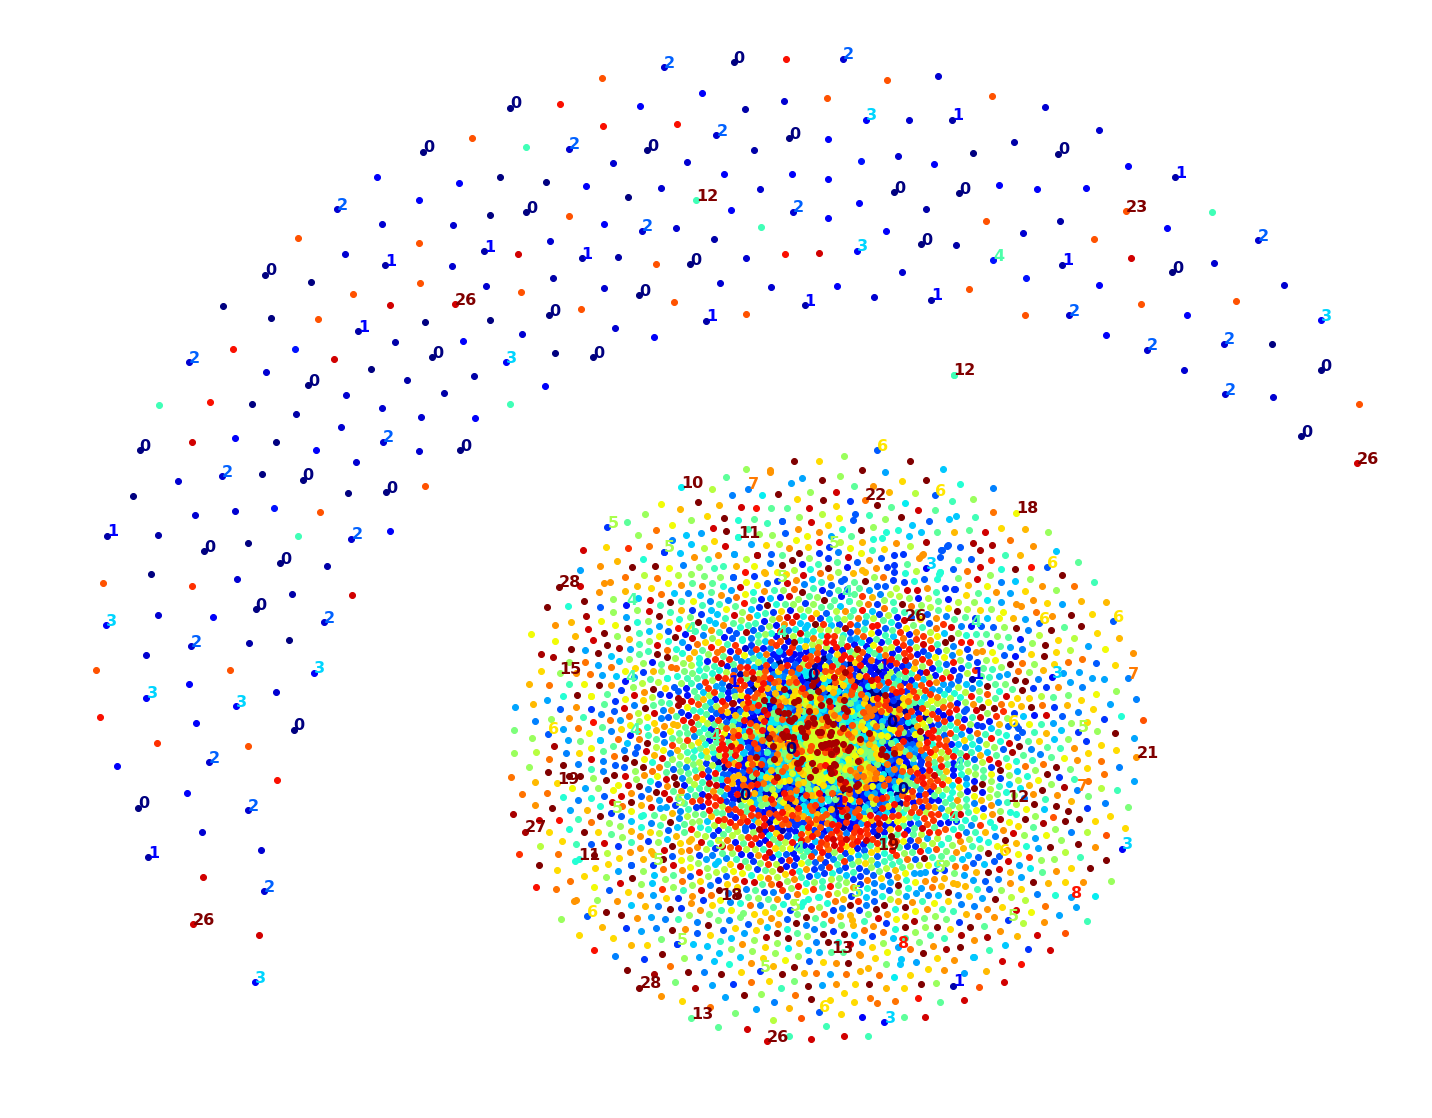

In [23]:
plot_keystrokes(data_embedded, labels, figsize=(25, 20))

## Clustering just 'spacebar' and 'a' keys

Because there is no identifiable clustering in the renderings above, I will start by using just the datasets for the 'a' key and spacebar. Once I devise an effective method for dimension-reduction and clustering these two keys, I will attempt to apply that same process to all 29 keys and observe its effectiveness.

In [11]:
idx = (labels == 0) | (labels == 28)
data_subset = data[idx]
labels_subset = labels[idx]

In [13]:
scaled_data_subset = MinMaxScaler().fit_transform(data_subset)
t0 = time.time()
embedded_data_subset = TSNE().fit_transform(scaled_data_subset)
t1 = time.time()
print(f'Elapsed time: {t1 - t0}s')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Elapsed time: 2.643625020980835s


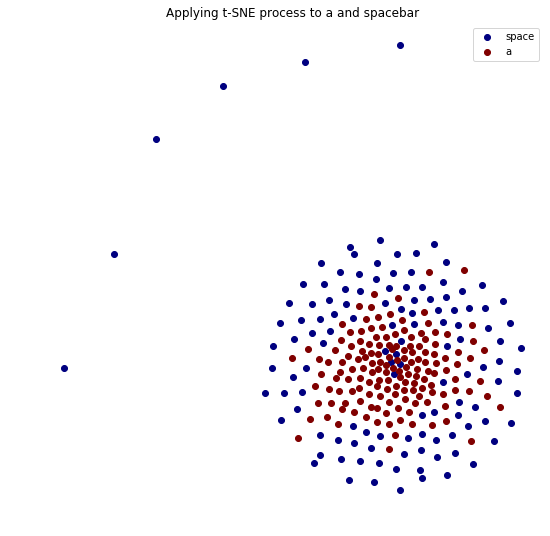

In [15]:
cmap = plt.cm.get_cmap('jet')
plt.figure(figsize=(9,9))
for digit in (0, 28):
    plt.scatter(embedded_data_subset[labels_subset == digit, 0], 
                embedded_data_subset[labels_subset == digit, 1],
                c=[cmap(digit / 28)])
plt.title('Applying t-SNE process to a and spacebar')
plt.legend({'a', 'space'})
plt.axis('off')
plt.show()

In [9]:
data

array([[ 1086,  2269,  3287, ...,    17,    17,     8],
       [-1099,  -858,  -332, ...,    -5,     1,    11],
       [  950,   421,  -471, ...,   -34,   -33,   -30],
       ...,
       [ -724,  -949,   539, ...,     0,    -4,    -5],
       [ -545,  -933,  -223, ...,    -7,    -9,    -7],
       [ -828, -1149,   125, ...,    -7,    -5,    -3]])

In [10]:
labels

array([ 0,  0,  0, ..., 28, 28, 28])